-  This notebook is to run active learning on current dataset and suggest next experimental plan

In [ ]:
# Add the src directory to sys.path
import sys
import os
sys.path.append(os.path.abspath('../src'))

In [1]:
import numpy as np
import torch
import gpytorch
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pickle
import scipy.stats as stats
from Active_learning import *
from utils import *

In [ ]:
# Construct input data for model 
df_input = pd.read_csv('df_combine_20240428.csv')
df_input['num_vesicles'] = df_input['num_vesicles'].round().astype(int)
df_input.iloc[:,0:7] = df_input.iloc[:,0:7].applymap(lambda x: np.log1p(x))
df_input=df_input.iloc[:, 0:8]
df_input.to_csv('../../data/20240419/df_input_20240429.csv', index=False)

In [6]:
torch.set_default_dtype(torch.float64)
tkwargs = {
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "dtype": torch.double,
}

In [4]:
df_input= pd.read_csv('../../data/20240419/df_input_20240429.csv')
df_input

,Total_decanoic acid_Mass,Total_decanoate_Mass,Total_decylamine_Mass,Total_decyl trimethylamine_Mass,Total_decylsulfate_Mass,Total_decanol_Mass,Total_monocaprin_Mass,num_vesicles
0,0.615186,0.955511,1.231101,1.552868,1.677097,0.441476,0.579418,22
1,1.487270,0.644482,0.175633,1.056053,1.216395,0.207827,0.107059,9
2,1.163151,0.705570,1.294727,1.787584,1.658228,0.159138,0.202941,6
3,1.531476,1.787584,0.381855,0.071390,1.475907,0.589175,0.113329,2
4,1.170933,1.441019,1.677097,0.885832,1.011601,0.750236,0.300105,36
5,0.368109,1.609438,1.464412,1.718292,1.594324,0.629941,0.158712,40
6,1.691018,1.762159,1.458615,1.029619,0.601580,0.431782,0.612479,22
7,1.589235,1.589235,0.559616,1.744843,1.727221,0.260054,0.235072,39
8,0.598837,0.270027,0.451076,0.081580,1.542229,0.812041,0.418710,9
9,0.343590,1.367366,0.665262,1.231101,1.779181,0.127953,0.318454,30


In [5]:
obf = objective_function(df_input, threshold=1)
obf

array([ -7.05265664,  -4.89471877,  -6.97133892,  -5.9507155 ,
        -7.23682195,  -7.54322876,  -7.58725302,  -7.70527572,
        -4.17449945,  -5.83290729,  -5.6929427 ,  -7.66172635,
        -5.79461384,  -7.90284051,  -6.50152111,  -6.76679294,
        -8.03449222, -11.05506473,  -6.42876735,  -5.0370156 ,
        -5.98657454,  -5.84644849,  -6.2650678 ,  -8.50223575,
        -5.71160951,  -7.99689898,  -8.20267354,  -5.07886925,
        -6.71550966,  -8.44083819,  -8.16529147,  -4.44763413,
        -5.78149151,  -7.05496602,  -6.35570382,  -7.53963647,
        -5.86541527,  -4.92844135,  -6.03748302,  -6.439957  ,
        -7.52409248,  -6.74521409,  -5.47201209,  -6.65133391,
        -6.29390745,  -7.30947626,  -6.85260537,  -6.10877263])

In [37]:
obf.max()

-4.174499452753595

In [11]:
init_x, init_y, best_init_y = df_input.iloc[:,0:7].values, obf, obf.max()
init_x, init_y, best_init_y = torch.tensor(init_x), torch.tensor(init_y).unsqueeze(-1), torch.tensor(best_init_y).item()

batch_size=24

priors = {
    'lengthscale': (3.0, 6.0),
    'outputscale': (2.0, 0.15),
    'kernel_smooth': 2.5}

bounds = torch.tensor([[0., 0., 0., 0., 0., 0., 0.],[5., 5., 5., 5., 5., 1.5, 1.0]])
bounds = torch.log1p(bounds)
bounds

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.7918, 1.7918, 1.7918, 1.7918, 1.7918, 0.9163, 0.6931]])

In [8]:
model_bo = build_model(init_x, init_y, priors)

Mean Squared Error (MSE): 1.4877704354619585e-05
Mean Absolute Error (MAE): 0.0022334929032178743
R-squared (R2) score: 0.9999902764742752


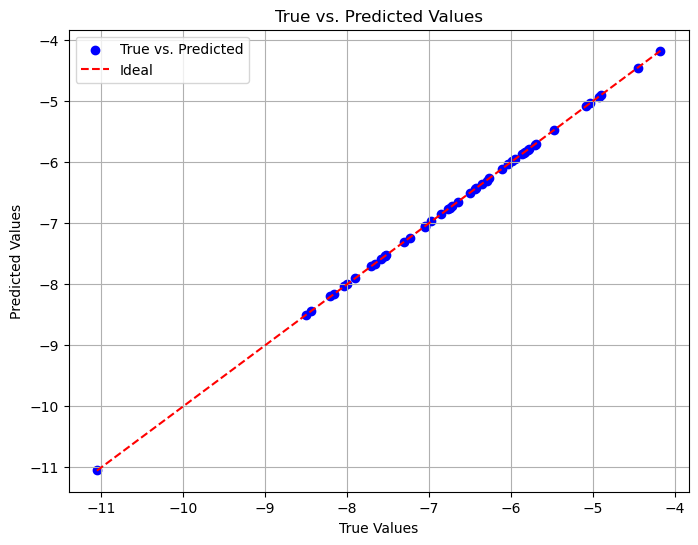

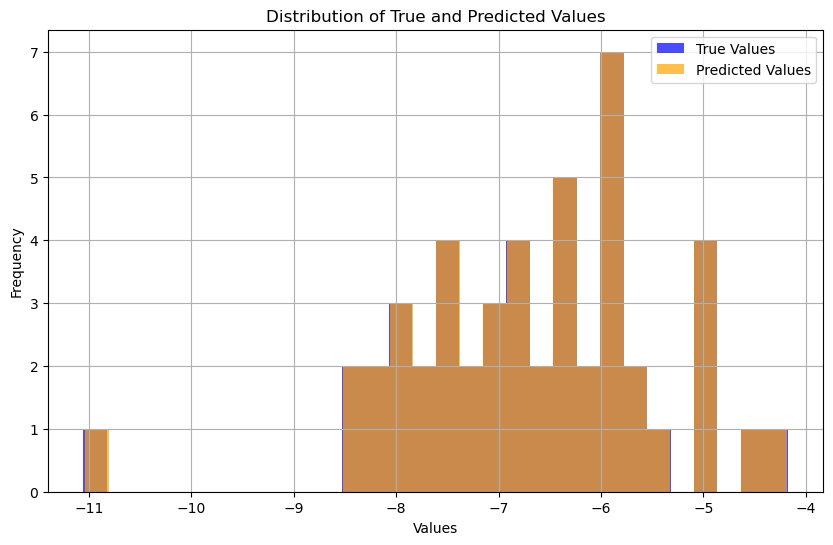

Mean Squared Error (MSE): 1.4877704354619585e-05
Mean Absolute Error (MAE): 0.0022334929032178743
R-squared (R2) score: 0.9999902764742752


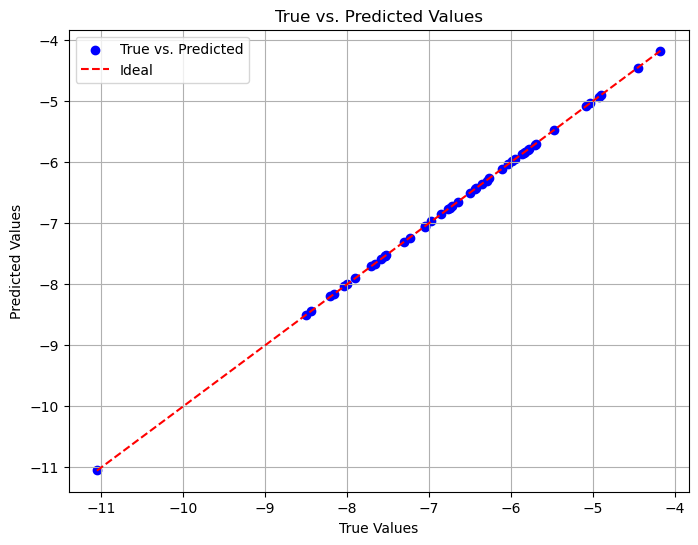

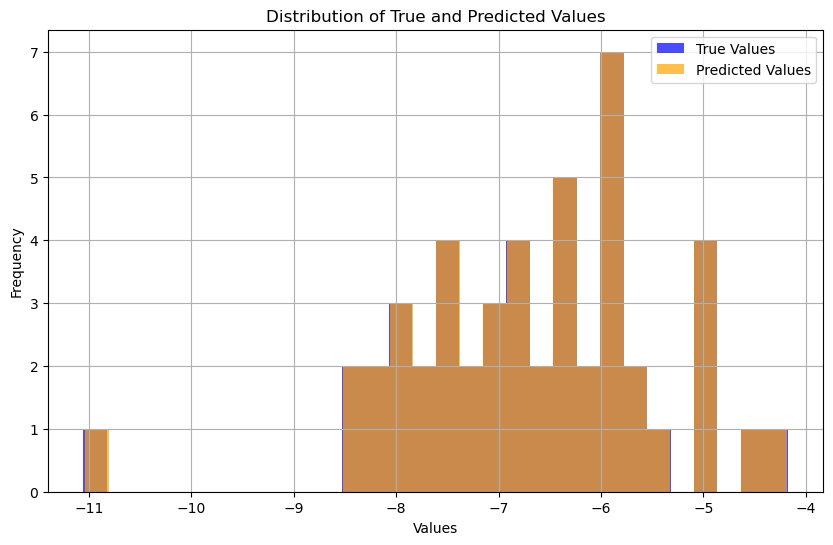

In [12]:
new_candidates1, ac_values1, model1, ac_func1 = get_candidates(init_x, init_y, best_init_y, model_bo, bounds, batch_size, acq_type='EI')
new_candidates2, ac_values2, model2, ac_func2 = get_candidates(init_x, init_y, best_init_y, model_bo, bounds, batch_size, acq_type='PI')

In [30]:
# Store the objects in a dictionary
data = {
    "new_candidates1": new_candidates1,
    "ac_values1": ac_values1,
    "model1": model1,
    "ac_func1": ac_func1,
    "new_candidates2": new_candidates2,
    "ac_values2": ac_values2,
    "model2": model2,
    "ac_func2": ac_func2
}

path = '../../20240419/model/'
pickle_file_name = "model_20240429.pkl"  

with open(path+pickle_file_name, "wb") as f:
    pickle.dump(data, f)

In [14]:
solutes = ['decanoic acid', 'decanoate', 'decylamine', 'decyl trimethylamine', 'decylsulfate', 'decanol', 'monocaprin']

In [23]:
original_scale_tensor1 = torch.expm1(new_candidates1)
original_scale_tensor2 = torch.expm1(new_candidates2)

stacked_tensor = torch.cat((original_scale_tensor1, original_scale_tensor2), dim=0)

In [35]:
original_scale_df

,decanoic acid,decanoate,decylamine,decyl trimethylamine,decylsulfate,decanol,monocaprin
0,0.501552,0.442762,0.032791,1.406463e+00,1.744199,0.400951,0.346850
1,5.000000,0.911928,0.060187,0.000000e+00,1.132718,0.112504,0.400491
2,3.626595,0.376999,0.569348,6.849229e-01,0.919348,0.000000,0.278613
3,0.433506,0.991216,0.023667,0.000000e+00,2.844044,0.474186,0.540702
4,3.004924,0.347143,1.601485,2.668963e+00,0.487219,0.768595,0.203673
5,0.862375,0.562572,0.828489,1.198061e+00,0.867446,0.449368,0.148496
6,1.236457,0.454712,0.195255,8.762263e-01,1.538329,1.164010,0.367506
7,1.043806,0.245956,0.420948,1.640136e+00,0.842086,0.775707,0.282526
8,0.692461,0.171081,0.600633,0.000000e+00,1.747617,1.500000,0.383020
9,1.612535,0.000000,2.529524,1.246146e-01,0.608470,0.935784,0.269463


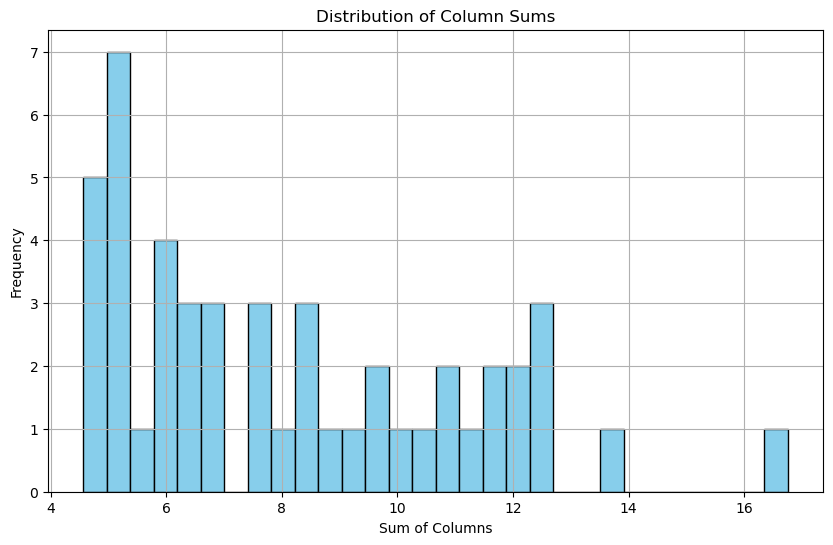

In [6]:
column_sums = original_scale_df.sum(axis=1)

# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.hist(column_sums, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Column Sums')
plt.xlabel('Sum of Columns')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [7]:
original_scale_df

,decanoic acid,decanoate,decylamine,decyl trimethylamine,decylsulfate,decanol,monocaprin
0,0.501552,0.442762,0.032791,1.406463e+00,1.744199,0.400951,0.346850
1,5.000000,0.911928,0.060187,0.000000e+00,1.132718,0.112504,0.400491
2,3.626595,0.376999,0.569348,6.849229e-01,0.919348,0.000000,0.278613
3,0.433506,0.991216,0.023667,0.000000e+00,2.844044,0.474186,0.540702
4,3.004924,0.347143,1.601485,2.668963e+00,0.487219,0.768595,0.203673
5,0.862375,0.562572,0.828489,1.198061e+00,0.867446,0.449368,0.148496
6,1.236457,0.454712,0.195255,8.762263e-01,1.538329,1.164010,0.367506
7,1.043806,0.245956,0.420948,1.640136e+00,0.842086,0.775707,0.282526
8,0.692461,0.171081,0.600633,0.000000e+00,1.747617,1.500000,0.383020
9,1.612535,0.000000,2.529524,1.246146e-01,0.608470,0.935784,0.269463


In [29]:
original_scale_df.to_csv('original_scale_df_hybrid_20240429.csv', index=False)

In [5]:
original_scale_df = pd.read_csv('original_scale_df_hybrid_20240429.csv')

In [25]:
dispense_df = get_dispense_volume(original_scale_df, solutes, allow_zero=False)
len(dispense_df)

32

In [26]:
dispense_df = get_dispense_volume(original_scale_df, solutes, allow_zero=True)
dispense_df

,decanoic acid (50 mM),decanoic acid (10 mM),decanoic acid (2 mM),decanoate (50 mM),decanoate (10 mM),decanoate (2 mM),decylamine (50 mM),decylamine (10 mM),decylamine (2 mM),decyl trimethylamine (50 mM),decyl trimethylamine (10 mM),decyl trimethylamine (2 mM),decylsulfate (50 mM),decylsulfate (10 mM),decylsulfate (2 mM),decanol (15 mM),decanol (3 mM),monocaprin (10 mM),monocaprin (2 mM)
0,0.0,10.0,0.0,0.0,8.9,0.0,0.0,0.0,3.3,5.6,0.0,0.0,7.0,0.0,0.0,5.3,0.0,6.9,0.0
1,20.0,0.0,0.0,0.0,18.2,0.0,0.0,0.0,6.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,7.5,8.0,0.0
2,14.5,0.0,0.0,0.0,7.5,0.0,0.0,11.4,0.0,0.0,13.7,0.0,0.0,18.4,0.0,0.0,0.0,5.6,0.0
3,0.0,8.7,0.0,0.0,19.8,0.0,0.0,0.0,2.4,0.0,0.0,0.0,11.4,0.0,0.0,6.3,0.0,10.8,0.0
4,12.0,0.0,0.0,0.0,6.9,0.0,6.4,0.0,0.0,10.7,0.0,0.0,0.0,9.7,0.0,10.2,0.0,4.1,0.0
5,0.0,17.2,0.0,0.0,11.3,0.0,0.0,16.6,0.0,4.8,0.0,0.0,0.0,17.3,0.0,6.0,0.0,0.0,14.8
6,4.9,0.0,0.0,0.0,9.1,0.0,0.0,0.0,19.5,0.0,17.5,0.0,6.2,0.0,0.0,15.5,0.0,7.4,0.0
7,4.2,0.0,0.0,0.0,4.9,0.0,0.0,8.4,0.0,6.6,0.0,0.0,0.0,16.8,0.0,10.3,0.0,5.7,0.0
8,0.0,13.8,0.0,0.0,0.0,17.1,0.0,12.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,20.0,0.0,7.7,0.0
9,6.5,0.0,0.0,0.0,0.0,0.0,10.1,0.0,0.0,0.0,0.0,12.5,0.0,12.2,0.0,12.5,0.0,5.4,0.0


In [27]:
dispense_df.to_csv('dispense_df_hybrid_20240429.csv', index=False)

In [28]:
len(dispense_df)

48

In [34]:
# Create dataframe for dispense volume
df_repeated = pd.concat([dispense_df] * 2, ignore_index=True)

# Create Labware_Deck_Slot column
df_repeated['Labware_Deck_Slot'] = [1] * 48 + [2] * 48

# Create Destination_Well column based on the well pattern
destination_well = []

for letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
    for i in range(1, 13):
        destination_well.append(f"{letter}{i}")

df_repeated['Destination_Well'] = destination_well

# Rearrange columns
df_repeated = df_repeated[['Labware_Deck_Slot', 'Destination_Well'] + list(dispense_df.columns)]

# Save to Excel with two sheets
with pd.ExcelWriter('../../data/20240419/dispense_df_20240429.xlsx') as writer:

    df_repeated.to_excel(writer, sheet_name='Plate1', index=False)

    df_repeated.to_excel(writer, sheet_name='Plate2', index=False)